In [1]:
import numpy as np
import pandas as pd
import scipy
import spacy
import sys
from collections import Counter
from time import time
import torch
from sklearn import model_selection
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [104]:
data = pd.read_csv('top30.csv')
data['lenght']=data['content'].apply(len)
data=data.sort_values(by='lenght',ascending=False)[4:]
names = data.author.value_counts().index.tolist()
minarticles = data.author[data.author == names[-1]].value_counts()
names.remove('Breitbart News')

In [6]:
# # Make a DataFrame with articles by our chosen authors
# # Include author names and article titles.

# # Make a list of the 10 chosen author names
# names = data.author.value_counts()[data.author.value_counts()>100][-30:].index.tolist()

# # DataFrame for articles of all chosen authors
# authors_data = pd.DataFrame()
# for name in names:
#     # Select each author's data
#     articles = data[data.author==name][:minarticles[0]][['title','content','author']]
#     # Append it to the DataFrame
#     authors_data = authors_data.append(articles)
# authors_data = authors_data.reset_index().drop('index',1)
    
# authors_data.head()

In [7]:
# # Look for duplicates
# print('Number of articles:',authors_data.shape[0])
# print('Unique articles:',len(np.unique(authors_data.index)))

# # Number of authors
# print('Unique authors:',len(np.unique(authors_data.author)))
# print('')
# print('Articles by author:\n')

# # Articles counts by author
# print(authors_data.author.value_counts())

In [8]:
# #!{sys.executable} -m spacy download en
# t0 = time()

# # Load spacy NLP object
# nlp = spacy.load("en_core_web_sm")
# nlp.max_length = 3000000
# # A list to store common words by all authors
# common_words = []

# # A dictionary to store the spacy_doc object of each author
# authors_docs = {}

# for name in names:
#     # Corpus is all the text written by that author
#     corpus = ""
#     # Grab all rows of current author, along the 'content' column
#     author_content = authors_data.loc[authors_data.author==name,'content']
    
#     # Merge all articles in to the author's corpus
#     for article in author_content:
#         corpus = corpus + article
#     # Let Spacy parse the author's body of text
#     doc = nlp(corpus)
    
#     # Store the doc in the dictionary
#     authors_docs[name] = doc
        
#     # Filter out punctuation and stop words.
#     lemmas = [token.lemma_ for token in doc
#                 if not token.is_punct and not token.is_stop]
        
#     # Return the most common words of that author's corpus.
#     bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
#     # Add them to the list of words by all authors.
#     for word in bow:
#         common_words.append(word)

# # Eliminate duplicates
# common_words = set(common_words)
    
# print('Total number of common words:',len(common_words))
# print("done in %0.3fs" % (time() - t0))

In [9]:
# # Let's see our 10 authors in the dictionary
# lengths = []
# for k,v in authors_docs.items():
#     print(k,'corpus contains',len(v),' words.')
#     lengths.append(len(v))



In [10]:
# # check for lower case words
# common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
# print('Count of all common_words:',len(common_words))
# print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# # Turn all common_words into lower case
# common_words = [word.lower() for word in common_words]
# print('Count of lowercase common_words (After Conversion):',np.sum([word.islower() for word in common_words]))


# # We must remove these in to avoid conflicts with existing features.
# if 'author' in common_words:
#     common_words.remove('author')
# if 'title' in common_words:
#     common_words.remove('title')
# if 'content' in common_words:
#     common_words.remove('content')

In [11]:
# # Count the number of times a common_word appears in each article
# # (about 3Hrs processing)

# bow_counts = pd.DataFrame()
# for name in names:
#     # Select X articles of that author
#     articles = authors_data.loc[authors_data.author==name,:]
#     bow_counts = bow_counts.append(articles)
# bow_counts = bow_counts.reset_index().drop('index',1)

# # Use common_words as the columns of a temporary DataFrame
# df = pd.DataFrame(columns=common_words)

# # Join BOW features with the author's content
# bow_counts = bow_counts.join(df)

# # Initialize rows with zeroes
# bow_counts = bow_counts.loc[:,~bow_counts.columns.duplicated()].copy()
# bow_counts.loc[:,common_words] = 0

# # Fill the DataFrame with counts of each feature in each article
# t0 = time()
# for i, article in enumerate(bow_counts.content):
#     doc = nlp(article)
#     for token in doc:
#         if token.lemma_.lower() in common_words:
#             bow_counts.loc[i,token.lemma_.lower()] += 1
#     # Print a message every X articles
#     if i % 50 == 0:
#         if time()-t0 < 3600: # if less than an hour in seconds
#             print("Article ",i," done after ",(time()-t0)/60,' minutes.')
#         else:
#             print("Article ",i," done after ",(time()-t0)/60/60,' hours.')

In [12]:
# This saves the long-awaited data into a pickle file for easy recovery
#bow_counts.to_pickle('bow_counts338')
# Read it back in with the following
bow_counts = pd.read_pickle('bow_counts338')

In [76]:
y = bow_counts['author']
counter = 0
newy = np.zeros(len(y))
last = y[0]
for i in range(len(y)):
    if y[i] != last:
        counter+=1
    newy[i] = counter
    last = y[i]
X = bow_counts.drop(['content','author','title'], 1)
X = X.loc[:,~X.columns.duplicated()].copy()
X = X.to_numpy()
N, M = X.shape
import torch.nn as nn
#X = scipy.stats.zscore(X)
n_hidden_units = 2     # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)


class Net(nn.Module):
    def __init__(self,D_in,H,H2,H3,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,H2)
        #self.linear3=nn.Linear(H2,D_out)
        self.linear3=nn.Linear(H2,H3)
        self.linear4=nn.Linear(H3,D_out)
        
    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=F.relu(self.linear3(x))  
        #x=self.linear3(x)
        x=self.linear4(x)
        return x
#model=Net(M,300,150,30)
loss_fn = torch.nn.CrossEntropyLoss()

C:\Users\penna\AppData\Local\Temp\ipykernel_13012\1546452035.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = bow_counts.drop(['content','author','title'], 1)


In [14]:
batch_size=128
k=10
splits=KFold(n_splits=k,shuffle=True)

In [15]:
#dataset = np.column_stack((X,newy))
X = X.astype('float32')
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(newy)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len
dataset=Data()

In [16]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    #for images, labels in dataloader:
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output,labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for inputs, labels in dataloader:

        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)
        loss=loss_fn(output,labels.long())
        valid_loss+=loss.item()*inputs.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [29]:
H1 = round(math.sqrt(M * 30))
H2 = round(H1/2)
H3 = round(H2/2)
foldperf={'fold1': {}, 'fold2': {}, 'fold3': {}, 'fold4': {}, 'fold5': {}, 'fold6': {},'fold7': {},'fold8': {}, 'fold9': {}, 'fold10': {}}
num_epochs=20
learning_rates = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001]
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for learning_rate in learning_rates:
        model = Net(M,H1,H2,H3,30)
        model.to(device)
        #learning_rate=0.000085
        #optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        #lrdict = {}
        history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    
        for epoch in range(num_epochs):
            train_loss, train_correct=train_epoch(model,device,train_loader,loss_fn,optimizer)
            test_loss, test_correct=valid_epoch(model,device,test_loader,loss_fn)
    
            train_loss = train_loss / len(train_loader.sampler)
            train_acc = train_correct / len(train_loader.sampler) * 100
            test_loss = test_loss / len(test_loader.sampler)
            test_acc = test_correct / len(test_loader.sampler) * 100
    
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                                 num_epochs,
                                                                                                                 train_loss,
                                                                                                                 test_loss,
                                                                                                                 train_acc,
                                                                                                                 test_acc))
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)
        #lrdict['lr{}'.format(learning_rate)] = history
        foldperf['fold{}'.format(fold+1)]['lr{}'.format(learning_rate)] = history#['lr{}'.format(learning_rate)] = history

Fold 1
Epoch:1/20 AVG Training Loss:3.402 AVG Test Loss:3.396 AVG Training Acc 3.96 % AVG Test Acc 5.20 %
Epoch:2/20 AVG Training Loss:3.389 AVG Test Loss:3.384 AVG Training Acc 6.03 % AVG Test Acc 6.73 %
Epoch:3/20 AVG Training Loss:3.373 AVG Test Loss:3.369 AVG Training Acc 7.10 % AVG Test Acc 6.32 %
Epoch:4/20 AVG Training Loss:3.353 AVG Test Loss:3.349 AVG Training Acc 7.60 % AVG Test Acc 6.01 %
Epoch:5/20 AVG Training Loss:3.327 AVG Test Loss:3.322 AVG Training Acc 7.38 % AVG Test Acc 5.30 %
Epoch:6/20 AVG Training Loss:3.294 AVG Test Loss:3.289 AVG Training Acc 8.11 % AVG Test Acc 7.75 %
Epoch:7/20 AVG Training Loss:3.253 AVG Test Loss:3.248 AVG Training Acc 11.90 % AVG Test Acc 11.82 %
Epoch:8/20 AVG Training Loss:3.202 AVG Test Loss:3.198 AVG Training Acc 18.56 % AVG Test Acc 17.23 %
Epoch:9/20 AVG Training Loss:3.143 AVG Test Loss:3.141 AVG Training Acc 22.81 % AVG Test Acc 22.43 %
Epoch:10/20 AVG Training Loss:3.077 AVG Test Loss:3.082 AVG Training Acc 27.91 % AVG Test Acc 27

Epoch:2/20 AVG Training Loss:3.250 AVG Test Loss:3.173 AVG Training Acc 17.57 % AVG Test Acc 18.76 %
Epoch:3/20 AVG Training Loss:2.984 AVG Test Loss:2.871 AVG Training Acc 27.26 % AVG Test Acc 29.97 %
Epoch:4/20 AVG Training Loss:2.614 AVG Test Loss:2.506 AVG Training Acc 40.26 % AVG Test Acc 40.77 %
Epoch:5/20 AVG Training Loss:2.218 AVG Test Loss:2.164 AVG Training Acc 52.62 % AVG Test Acc 53.31 %
Epoch:6/20 AVG Training Loss:1.869 AVG Test Loss:1.870 AVG Training Acc 63.51 % AVG Test Acc 60.04 %
Epoch:7/20 AVG Training Loss:1.586 AVG Test Loss:1.646 AVG Training Acc 72.18 % AVG Test Acc 65.65 %
Epoch:8/20 AVG Training Loss:1.351 AVG Test Loss:1.470 AVG Training Acc 76.88 % AVG Test Acc 69.72 %
Epoch:9/20 AVG Training Loss:1.159 AVG Test Loss:1.321 AVG Training Acc 80.74 % AVG Test Acc 71.97 %
Epoch:10/20 AVG Training Loss:0.992 AVG Test Loss:1.196 AVG Training Acc 83.55 % AVG Test Acc 74.41 %
Epoch:11/20 AVG Training Loss:0.858 AVG Test Loss:1.094 AVG Training Acc 85.48 % AVG Test 

Epoch:3/20 AVG Training Loss:2.350 AVG Test Loss:2.104 AVG Training Acc 49.17 % AVG Test Acc 55.66 %
Epoch:4/20 AVG Training Loss:1.737 AVG Test Loss:1.637 AVG Training Acc 67.63 % AVG Test Acc 66.16 %
Epoch:5/20 AVG Training Loss:1.302 AVG Test Loss:1.329 AVG Training Acc 76.70 % AVG Test Acc 71.87 %
Epoch:6/20 AVG Training Loss:1.003 AVG Test Loss:1.129 AVG Training Acc 82.73 % AVG Test Acc 73.09 %
Epoch:7/20 AVG Training Loss:0.791 AVG Test Loss:0.987 AVG Training Acc 86.03 % AVG Test Acc 77.06 %
Epoch:8/20 AVG Training Loss:0.634 AVG Test Loss:0.886 AVG Training Acc 89.59 % AVG Test Acc 79.20 %
Epoch:9/20 AVG Training Loss:0.518 AVG Test Loss:0.810 AVG Training Acc 91.62 % AVG Test Acc 80.43 %
Epoch:10/20 AVG Training Loss:0.425 AVG Test Loss:0.773 AVG Training Acc 93.82 % AVG Test Acc 79.82 %
Epoch:11/20 AVG Training Loss:0.352 AVG Test Loss:0.717 AVG Training Acc 94.75 % AVG Test Acc 80.53 %
Epoch:12/20 AVG Training Loss:0.290 AVG Test Loss:0.693 AVG Training Acc 96.08 % AVG Test

Epoch:4/20 AVG Training Loss:3.026 AVG Test Loss:2.894 AVG Training Acc 26.38 % AVG Test Acc 33.33 %
Epoch:5/20 AVG Training Loss:2.787 AVG Test Loss:2.647 AVG Training Acc 38.01 % AVG Test Acc 42.20 %
Epoch:6/20 AVG Training Loss:2.522 AVG Test Loss:2.410 AVG Training Acc 46.60 % AVG Test Acc 48.32 %
Epoch:7/20 AVG Training Loss:2.271 AVG Test Loss:2.196 AVG Training Acc 53.57 % AVG Test Acc 52.19 %
Epoch:8/20 AVG Training Loss:2.043 AVG Test Loss:2.009 AVG Training Acc 59.55 % AVG Test Acc 58.21 %
Epoch:9/20 AVG Training Loss:1.843 AVG Test Loss:1.846 AVG Training Acc 65.67 % AVG Test Acc 61.88 %
Epoch:10/20 AVG Training Loss:1.666 AVG Test Loss:1.711 AVG Training Acc 69.78 % AVG Test Acc 64.83 %
Epoch:11/20 AVG Training Loss:1.509 AVG Test Loss:1.586 AVG Training Acc 74.50 % AVG Test Acc 69.83 %
Epoch:12/20 AVG Training Loss:1.371 AVG Test Loss:1.479 AVG Training Acc 78.26 % AVG Test Acc 73.50 %
Epoch:13/20 AVG Training Loss:1.249 AVG Test Loss:1.384 AVG Training Acc 80.38 % AVG Tes

Epoch:5/20 AVG Training Loss:1.622 AVG Test Loss:1.589 AVG Training Acc 68.79 % AVG Test Acc 66.06 %
Epoch:6/20 AVG Training Loss:1.309 AVG Test Loss:1.376 AVG Training Acc 76.45 % AVG Test Acc 71.76 %
Epoch:7/20 AVG Training Loss:1.070 AVG Test Loss:1.210 AVG Training Acc 81.78 % AVG Test Acc 77.57 %
Epoch:8/20 AVG Training Loss:0.886 AVG Test Loss:1.079 AVG Training Acc 85.61 % AVG Test Acc 79.31 %
Epoch:9/20 AVG Training Loss:0.739 AVG Test Loss:0.982 AVG Training Acc 88.52 % AVG Test Acc 80.43 %
Epoch:10/20 AVG Training Loss:0.619 AVG Test Loss:0.898 AVG Training Acc 90.64 % AVG Test Acc 81.96 %
Epoch:11/20 AVG Training Loss:0.520 AVG Test Loss:0.845 AVG Training Acc 92.42 % AVG Test Acc 81.96 %
Epoch:12/20 AVG Training Loss:0.441 AVG Test Loss:0.793 AVG Training Acc 93.58 % AVG Test Acc 83.08 %
Epoch:13/20 AVG Training Loss:0.373 AVG Test Loss:0.763 AVG Training Acc 94.82 % AVG Test Acc 82.47 %
Epoch:14/20 AVG Training Loss:0.318 AVG Test Loss:0.740 AVG Training Acc 95.85 % AVG Te

Epoch:6/20 AVG Training Loss:3.284 AVG Test Loss:3.269 AVG Training Acc 16.45 % AVG Test Acc 14.39 %
Epoch:7/20 AVG Training Loss:3.236 AVG Test Loss:3.222 AVG Training Acc 18.90 % AVG Test Acc 17.55 %
Epoch:8/20 AVG Training Loss:3.181 AVG Test Loss:3.167 AVG Training Acc 22.41 % AVG Test Acc 20.41 %
Epoch:9/20 AVG Training Loss:3.117 AVG Test Loss:3.106 AVG Training Acc 24.45 % AVG Test Acc 22.96 %
Epoch:10/20 AVG Training Loss:3.047 AVG Test Loss:3.041 AVG Training Acc 26.83 % AVG Test Acc 25.31 %
Epoch:11/20 AVG Training Loss:2.972 AVG Test Loss:2.973 AVG Training Acc 29.12 % AVG Test Acc 27.65 %
Epoch:12/20 AVG Training Loss:2.894 AVG Test Loss:2.901 AVG Training Acc 32.32 % AVG Test Acc 29.59 %
Epoch:13/20 AVG Training Loss:2.814 AVG Test Loss:2.831 AVG Training Acc 35.14 % AVG Test Acc 31.73 %
Epoch:14/20 AVG Training Loss:2.733 AVG Test Loss:2.759 AVG Training Acc 37.44 % AVG Test Acc 34.69 %
Epoch:15/20 AVG Training Loss:2.653 AVG Test Loss:2.688 AVG Training Acc 40.92 % AVG T

Epoch:7/20 AVG Training Loss:1.588 AVG Test Loss:1.676 AVG Training Acc 70.12 % AVG Test Acc 64.29 %
Epoch:8/20 AVG Training Loss:1.354 AVG Test Loss:1.502 AVG Training Acc 75.16 % AVG Test Acc 68.78 %
Epoch:9/20 AVG Training Loss:1.160 AVG Test Loss:1.360 AVG Training Acc 79.60 % AVG Test Acc 72.65 %
Epoch:10/20 AVG Training Loss:1.002 AVG Test Loss:1.242 AVG Training Acc 83.68 % AVG Test Acc 75.71 %
Epoch:11/20 AVG Training Loss:0.870 AVG Test Loss:1.149 AVG Training Acc 86.35 % AVG Test Acc 77.86 %
Epoch:12/20 AVG Training Loss:0.759 AVG Test Loss:1.071 AVG Training Acc 88.32 % AVG Test Acc 79.49 %
Epoch:13/20 AVG Training Loss:0.665 AVG Test Loss:1.008 AVG Training Acc 89.78 % AVG Test Acc 80.00 %
Epoch:14/20 AVG Training Loss:0.581 AVG Test Loss:0.949 AVG Training Acc 91.63 % AVG Test Acc 81.12 %
Epoch:15/20 AVG Training Loss:0.511 AVG Test Loss:0.911 AVG Training Acc 92.55 % AVG Test Acc 82.14 %
Epoch:16/20 AVG Training Loss:0.451 AVG Test Loss:0.864 AVG Training Acc 93.52 % AVG 

Epoch:8/20 AVG Training Loss:0.637 AVG Test Loss:0.995 AVG Training Acc 89.23 % AVG Test Acc 79.29 %
Epoch:9/20 AVG Training Loss:0.518 AVG Test Loss:0.918 AVG Training Acc 91.40 % AVG Test Acc 81.33 %
Epoch:10/20 AVG Training Loss:0.426 AVG Test Loss:0.889 AVG Training Acc 93.29 % AVG Test Acc 81.63 %
Epoch:11/20 AVG Training Loss:0.351 AVG Test Loss:0.875 AVG Training Acc 94.96 % AVG Test Acc 82.45 %
Epoch:12/20 AVG Training Loss:0.290 AVG Test Loss:0.832 AVG Training Acc 96.04 % AVG Test Acc 83.27 %
Epoch:13/20 AVG Training Loss:0.242 AVG Test Loss:0.832 AVG Training Acc 97.20 % AVG Test Acc 83.37 %
Epoch:14/20 AVG Training Loss:0.201 AVG Test Loss:0.831 AVG Training Acc 97.79 % AVG Test Acc 82.86 %
Epoch:15/20 AVG Training Loss:0.168 AVG Test Loss:0.822 AVG Training Acc 98.54 % AVG Test Acc 83.78 %
Epoch:16/20 AVG Training Loss:0.141 AVG Test Loss:0.834 AVG Training Acc 98.89 % AVG Test Acc 83.06 %
Epoch:17/20 AVG Training Loss:0.118 AVG Test Loss:0.849 AVG Training Acc 99.14 % AVG

Epoch:9/20 AVG Training Loss:1.870 AVG Test Loss:1.919 AVG Training Acc 62.33 % AVG Test Acc 60.20 %
Epoch:10/20 AVG Training Loss:1.692 AVG Test Loss:1.772 AVG Training Acc 67.42 % AVG Test Acc 65.31 %
Epoch:11/20 AVG Training Loss:1.533 AVG Test Loss:1.651 AVG Training Acc 72.33 % AVG Test Acc 68.57 %
Epoch:12/20 AVG Training Loss:1.397 AVG Test Loss:1.544 AVG Training Acc 75.91 % AVG Test Acc 70.82 %
Epoch:13/20 AVG Training Loss:1.274 AVG Test Loss:1.456 AVG Training Acc 78.42 % AVG Test Acc 73.06 %
Epoch:14/20 AVG Training Loss:1.165 AVG Test Loss:1.370 AVG Training Acc 81.33 % AVG Test Acc 74.18 %
Epoch:15/20 AVG Training Loss:1.067 AVG Test Loss:1.300 AVG Training Acc 83.67 % AVG Test Acc 75.31 %
Epoch:16/20 AVG Training Loss:0.981 AVG Test Loss:1.233 AVG Training Acc 84.63 % AVG Test Acc 76.53 %
Epoch:17/20 AVG Training Loss:0.901 AVG Test Loss:1.174 AVG Training Acc 86.31 % AVG Test Acc 76.73 %
Epoch:18/20 AVG Training Loss:0.831 AVG Test Loss:1.124 AVG Training Acc 87.47 % AV

Epoch:10/20 AVG Training Loss:0.608 AVG Test Loss:0.934 AVG Training Acc 90.56 % AVG Test Acc 79.80 %
Epoch:11/20 AVG Training Loss:0.507 AVG Test Loss:0.879 AVG Training Acc 92.36 % AVG Test Acc 81.12 %
Epoch:12/20 AVG Training Loss:0.426 AVG Test Loss:0.833 AVG Training Acc 93.88 % AVG Test Acc 80.41 %
Epoch:13/20 AVG Training Loss:0.361 AVG Test Loss:0.788 AVG Training Acc 94.87 % AVG Test Acc 81.43 %
Epoch:14/20 AVG Training Loss:0.308 AVG Test Loss:0.765 AVG Training Acc 95.96 % AVG Test Acc 82.65 %
Epoch:15/20 AVG Training Loss:0.262 AVG Test Loss:0.751 AVG Training Acc 96.89 % AVG Test Acc 81.73 %
Epoch:16/20 AVG Training Loss:0.224 AVG Test Loss:0.733 AVG Training Acc 97.53 % AVG Test Acc 82.86 %
Epoch:17/20 AVG Training Loss:0.192 AVG Test Loss:0.716 AVG Training Acc 98.11 % AVG Test Acc 83.37 %
Epoch:18/20 AVG Training Loss:0.165 AVG Test Loss:0.723 AVG Training Acc 98.55 % AVG Test Acc 83.37 %
Epoch:19/20 AVG Training Loss:0.142 AVG Test Loss:0.716 AVG Training Acc 98.93 % A

Epoch:11/20 AVG Training Loss:2.988 AVG Test Loss:2.980 AVG Training Acc 23.11 % AVG Test Acc 22.45 %
Epoch:12/20 AVG Training Loss:2.922 AVG Test Loss:2.913 AVG Training Acc 27.16 % AVG Test Acc 26.73 %
Epoch:13/20 AVG Training Loss:2.852 AVG Test Loss:2.845 AVG Training Acc 30.85 % AVG Test Acc 30.71 %
Epoch:14/20 AVG Training Loss:2.780 AVG Test Loss:2.773 AVG Training Acc 33.56 % AVG Test Acc 33.67 %
Epoch:15/20 AVG Training Loss:2.706 AVG Test Loss:2.703 AVG Training Acc 36.73 % AVG Test Acc 35.41 %
Epoch:16/20 AVG Training Loss:2.631 AVG Test Loss:2.629 AVG Training Acc 38.17 % AVG Test Acc 38.16 %
Epoch:17/20 AVG Training Loss:2.556 AVG Test Loss:2.558 AVG Training Acc 40.48 % AVG Test Acc 40.20 %
Epoch:18/20 AVG Training Loss:2.482 AVG Test Loss:2.488 AVG Training Acc 42.78 % AVG Test Acc 42.65 %
Epoch:19/20 AVG Training Loss:2.409 AVG Test Loss:2.419 AVG Training Acc 45.24 % AVG Test Acc 44.29 %
Epoch:20/20 AVG Training Loss:2.337 AVG Test Loss:2.351 AVG Training Acc 48.07 % A

Epoch:12/20 AVG Training Loss:0.755 AVG Test Loss:0.959 AVG Training Acc 88.52 % AVG Test Acc 78.06 %
Epoch:13/20 AVG Training Loss:0.661 AVG Test Loss:0.898 AVG Training Acc 90.23 % AVG Test Acc 78.67 %
Epoch:14/20 AVG Training Loss:0.579 AVG Test Loss:0.848 AVG Training Acc 91.50 % AVG Test Acc 78.37 %
Epoch:15/20 AVG Training Loss:0.510 AVG Test Loss:0.799 AVG Training Acc 92.76 % AVG Test Acc 80.20 %
Epoch:16/20 AVG Training Loss:0.450 AVG Test Loss:0.763 AVG Training Acc 93.72 % AVG Test Acc 81.22 %
Epoch:17/20 AVG Training Loss:0.399 AVG Test Loss:0.741 AVG Training Acc 94.51 % AVG Test Acc 81.63 %
Epoch:18/20 AVG Training Loss:0.355 AVG Test Loss:0.710 AVG Training Acc 95.39 % AVG Test Acc 81.94 %
Epoch:19/20 AVG Training Loss:0.314 AVG Test Loss:0.689 AVG Training Acc 95.98 % AVG Test Acc 82.55 %
Epoch:20/20 AVG Training Loss:0.279 AVG Test Loss:0.677 AVG Training Acc 96.52 % AVG Test Acc 81.84 %
Epoch:1/20 AVG Training Loss:3.379 AVG Test Loss:3.342 AVG Training Acc 4.22 % AVG

Epoch:13/20 AVG Training Loss:0.247 AVG Test Loss:0.662 AVG Training Acc 96.94 % AVG Test Acc 82.04 %
Epoch:14/20 AVG Training Loss:0.204 AVG Test Loss:0.654 AVG Training Acc 97.77 % AVG Test Acc 82.86 %
Epoch:15/20 AVG Training Loss:0.168 AVG Test Loss:0.642 AVG Training Acc 98.39 % AVG Test Acc 82.76 %
Epoch:16/20 AVG Training Loss:0.140 AVG Test Loss:0.635 AVG Training Acc 98.79 % AVG Test Acc 83.16 %
Epoch:17/20 AVG Training Loss:0.117 AVG Test Loss:0.638 AVG Training Acc 99.20 % AVG Test Acc 83.37 %
Epoch:18/20 AVG Training Loss:0.098 AVG Test Loss:0.660 AVG Training Acc 99.41 % AVG Test Acc 82.65 %
Epoch:19/20 AVG Training Loss:0.085 AVG Test Loss:0.644 AVG Training Acc 99.56 % AVG Test Acc 83.37 %
Epoch:20/20 AVG Training Loss:0.070 AVG Test Loss:0.637 AVG Training Acc 99.76 % AVG Test Acc 83.27 %
Epoch:1/20 AVG Training Loss:3.346 AVG Test Loss:3.221 AVG Training Acc 9.39 % AVG Test Acc 13.78 %
Epoch:2/20 AVG Training Loss:2.905 AVG Test Loss:2.541 AVG Training Acc 28.43 % AVG 

Epoch:14/20 AVG Training Loss:1.136 AVG Test Loss:1.285 AVG Training Acc 80.89 % AVG Test Acc 72.45 %
Epoch:15/20 AVG Training Loss:1.042 AVG Test Loss:1.215 AVG Training Acc 82.55 % AVG Test Acc 73.57 %
Epoch:16/20 AVG Training Loss:0.958 AVG Test Loss:1.154 AVG Training Acc 84.03 % AVG Test Acc 76.02 %
Epoch:17/20 AVG Training Loss:0.883 AVG Test Loss:1.098 AVG Training Acc 85.25 % AVG Test Acc 76.12 %
Epoch:18/20 AVG Training Loss:0.816 AVG Test Loss:1.053 AVG Training Acc 86.77 % AVG Test Acc 76.02 %
Epoch:19/20 AVG Training Loss:0.755 AVG Test Loss:1.013 AVG Training Acc 87.98 % AVG Test Acc 77.55 %
Epoch:20/20 AVG Training Loss:0.700 AVG Test Loss:0.971 AVG Training Acc 89.10 % AVG Test Acc 77.86 %
Epoch:1/20 AVG Training Loss:3.383 AVG Test Loss:3.349 AVG Training Acc 4.67 % AVG Test Acc 5.41 %
Epoch:2/20 AVG Training Loss:3.298 AVG Test Loss:3.215 AVG Training Acc 7.90 % AVG Test Acc 12.14 %
Epoch:3/20 AVG Training Loss:3.117 AVG Test Loss:2.978 AVG Training Acc 20.62 % AVG Tes

Epoch:15/20 AVG Training Loss:0.283 AVG Test Loss:0.699 AVG Training Acc 96.37 % AVG Test Acc 82.65 %
Epoch:16/20 AVG Training Loss:0.243 AVG Test Loss:0.682 AVG Training Acc 97.05 % AVG Test Acc 82.96 %
Epoch:17/20 AVG Training Loss:0.209 AVG Test Loss:0.667 AVG Training Acc 97.72 % AVG Test Acc 84.08 %
Epoch:18/20 AVG Training Loss:0.180 AVG Test Loss:0.656 AVG Training Acc 98.29 % AVG Test Acc 83.98 %
Epoch:19/20 AVG Training Loss:0.156 AVG Test Loss:0.663 AVG Training Acc 98.63 % AVG Test Acc 84.08 %
Epoch:20/20 AVG Training Loss:0.135 AVG Test Loss:0.650 AVG Training Acc 98.98 % AVG Test Acc 83.47 %
Epoch:1/20 AVG Training Loss:3.352 AVG Test Loss:3.245 AVG Training Acc 9.03 % AVG Test Acc 12.35 %
Epoch:2/20 AVG Training Loss:3.031 AVG Test Loss:2.755 AVG Training Acc 25.49 % AVG Test Acc 39.18 %
Epoch:3/20 AVG Training Loss:2.444 AVG Test Loss:2.185 AVG Training Acc 46.61 % AVG Test Acc 52.24 %
Epoch:4/20 AVG Training Loss:1.881 AVG Test Loss:1.744 AVG Training Acc 62.43 % AVG Te

Epoch:16/20 AVG Training Loss:2.612 AVG Test Loss:2.611 AVG Training Acc 43.75 % AVG Test Acc 40.20 %
Epoch:17/20 AVG Training Loss:2.529 AVG Test Loss:2.536 AVG Training Acc 46.17 % AVG Test Acc 42.04 %
Epoch:18/20 AVG Training Loss:2.449 AVG Test Loss:2.464 AVG Training Acc 48.36 % AVG Test Acc 45.00 %
Epoch:19/20 AVG Training Loss:2.371 AVG Test Loss:2.396 AVG Training Acc 50.60 % AVG Test Acc 46.84 %
Epoch:20/20 AVG Training Loss:2.295 AVG Test Loss:2.328 AVG Training Acc 52.69 % AVG Test Acc 48.37 %
Epoch:1/20 AVG Training Loss:3.394 AVG Test Loss:3.389 AVG Training Acc 4.64 % AVG Test Acc 5.20 %
Epoch:2/20 AVG Training Loss:3.370 AVG Test Loss:3.359 AVG Training Acc 7.79 % AVG Test Acc 8.67 %
Epoch:3/20 AVG Training Loss:3.325 AVG Test Loss:3.298 AVG Training Acc 12.33 % AVG Test Acc 11.73 %
Epoch:4/20 AVG Training Loss:3.245 AVG Test Loss:3.199 AVG Training Acc 15.73 % AVG Test Acc 16.02 %
Epoch:5/20 AVG Training Loss:3.131 AVG Test Loss:3.077 AVG Training Acc 22.22 % AVG Test A

Epoch:17/20 AVG Training Loss:0.385 AVG Test Loss:0.741 AVG Training Acc 94.37 % AVG Test Acc 83.27 %
Epoch:18/20 AVG Training Loss:0.342 AVG Test Loss:0.725 AVG Training Acc 95.13 % AVG Test Acc 82.86 %
Epoch:19/20 AVG Training Loss:0.305 AVG Test Loss:0.703 AVG Training Acc 95.85 % AVG Test Acc 83.98 %
Epoch:20/20 AVG Training Loss:0.272 AVG Test Loss:0.674 AVG Training Acc 96.30 % AVG Test Acc 83.67 %
Epoch:1/20 AVG Training Loss:3.373 AVG Test Loss:3.319 AVG Training Acc 8.97 % AVG Test Acc 12.96 %
Epoch:2/20 AVG Training Loss:3.187 AVG Test Loss:3.022 AVG Training Acc 21.75 % AVG Test Acc 26.84 %
Epoch:3/20 AVG Training Loss:2.794 AVG Test Loss:2.583 AVG Training Acc 33.98 % AVG Test Acc 38.98 %
Epoch:4/20 AVG Training Loss:2.324 AVG Test Loss:2.162 AVG Training Acc 49.82 % AVG Test Acc 55.41 %
Epoch:5/20 AVG Training Loss:1.891 AVG Test Loss:1.799 AVG Training Acc 63.78 % AVG Test Acc 65.61 %
Epoch:6/20 AVG Training Loss:1.537 AVG Test Loss:1.525 AVG Training Acc 72.86 % AVG Test

Epoch:18/20 AVG Training Loss:0.097 AVG Test Loss:0.555 AVG Training Acc 99.49 % AVG Test Acc 84.59 %
Epoch:19/20 AVG Training Loss:0.083 AVG Test Loss:0.544 AVG Training Acc 99.65 % AVG Test Acc 84.80 %
Epoch:20/20 AVG Training Loss:0.070 AVG Test Loss:0.549 AVG Training Acc 99.78 % AVG Test Acc 85.20 %
Epoch:1/20 AVG Training Loss:3.330 AVG Test Loss:3.182 AVG Training Acc 10.93 % AVG Test Acc 17.55 %
Epoch:2/20 AVG Training Loss:2.886 AVG Test Loss:2.562 AVG Training Acc 30.53 % AVG Test Acc 38.67 %
Epoch:3/20 AVG Training Loss:2.180 AVG Test Loss:1.948 AVG Training Acc 51.95 % AVG Test Acc 56.94 %
Epoch:4/20 AVG Training Loss:1.599 AVG Test Loss:1.539 AVG Training Acc 67.74 % AVG Test Acc 67.04 %
Epoch:5/20 AVG Training Loss:1.199 AVG Test Loss:1.261 AVG Training Acc 77.79 % AVG Test Acc 74.69 %
Epoch:6/20 AVG Training Loss:0.914 AVG Test Loss:1.065 AVG Training Acc 84.53 % AVG Test Acc 78.06 %
Epoch:7/20 AVG Training Loss:0.706 AVG Test Loss:0.930 AVG Training Acc 88.29 % AVG Test

Epoch:19/20 AVG Training Loss:0.742 AVG Test Loss:0.964 AVG Training Acc 88.29 % AVG Test Acc 76.84 %
Epoch:20/20 AVG Training Loss:0.685 AVG Test Loss:0.924 AVG Training Acc 89.05 % AVG Test Acc 77.14 %
Epoch:1/20 AVG Training Loss:3.390 AVG Test Loss:3.359 AVG Training Acc 6.95 % AVG Test Acc 8.16 %
Epoch:2/20 AVG Training Loss:3.293 AVG Test Loss:3.223 AVG Training Acc 11.24 % AVG Test Acc 17.96 %
Epoch:3/20 AVG Training Loss:3.089 AVG Test Loss:2.986 AVG Training Acc 25.44 % AVG Test Acc 29.80 %
Epoch:4/20 AVG Training Loss:2.804 AVG Test Loss:2.691 AVG Training Acc 34.78 % AVG Test Acc 34.80 %
Epoch:5/20 AVG Training Loss:2.495 AVG Test Loss:2.404 AVG Training Acc 42.60 % AVG Test Acc 41.73 %
Epoch:6/20 AVG Training Loss:2.196 AVG Test Loss:2.135 AVG Training Acc 52.54 % AVG Test Acc 50.82 %
Epoch:7/20 AVG Training Loss:1.919 AVG Test Loss:1.896 AVG Training Acc 62.09 % AVG Test Acc 58.37 %
Epoch:8/20 AVG Training Loss:1.680 AVG Test Loss:1.704 AVG Training Acc 68.45 % AVG Test Ac

Epoch:20/20 AVG Training Loss:0.131 AVG Test Loss:0.609 AVG Training Acc 99.00 % AVG Test Acc 81.63 %
Epoch:1/20 AVG Training Loss:3.340 AVG Test Loss:3.244 AVG Training Acc 6.78 % AVG Test Acc 8.06 %
Epoch:2/20 AVG Training Loss:3.016 AVG Test Loss:2.802 AVG Training Acc 22.05 % AVG Test Acc 32.14 %
Epoch:3/20 AVG Training Loss:2.451 AVG Test Loss:2.229 AVG Training Acc 44.22 % AVG Test Acc 48.06 %
Epoch:4/20 AVG Training Loss:1.895 AVG Test Loss:1.764 AVG Training Acc 61.81 % AVG Test Acc 61.84 %
Epoch:5/20 AVG Training Loss:1.470 AVG Test Loss:1.444 AVG Training Acc 74.11 % AVG Test Acc 70.10 %
Epoch:6/20 AVG Training Loss:1.166 AVG Test Loss:1.217 AVG Training Acc 79.86 % AVG Test Acc 73.27 %
Epoch:7/20 AVG Training Loss:0.934 AVG Test Loss:1.055 AVG Training Acc 85.12 % AVG Test Acc 75.71 %
Epoch:8/20 AVG Training Loss:0.758 AVG Test Loss:0.929 AVG Training Acc 87.66 % AVG Test Acc 79.08 %
Epoch:9/20 AVG Training Loss:0.620 AVG Test Loss:0.836 AVG Training Acc 90.31 % AVG Test Acc

Epoch:1/20 AVG Training Loss:3.396 AVG Test Loss:3.384 AVG Training Acc 4.23 % AVG Test Acc 4.90 %
Epoch:2/20 AVG Training Loss:3.365 AVG Test Loss:3.344 AVG Training Acc 6.23 % AVG Test Acc 6.94 %
Epoch:3/20 AVG Training Loss:3.317 AVG Test Loss:3.289 AVG Training Acc 6.82 % AVG Test Acc 6.84 %
Epoch:4/20 AVG Training Loss:3.249 AVG Test Loss:3.215 AVG Training Acc 9.07 % AVG Test Acc 11.73 %
Epoch:5/20 AVG Training Loss:3.151 AVG Test Loss:3.113 AVG Training Acc 16.84 % AVG Test Acc 19.08 %
Epoch:6/20 AVG Training Loss:3.025 AVG Test Loss:2.993 AVG Training Acc 27.82 % AVG Test Acc 28.78 %
Epoch:7/20 AVG Training Loss:2.875 AVG Test Loss:2.855 AVG Training Acc 38.01 % AVG Test Acc 33.98 %
Epoch:8/20 AVG Training Loss:2.708 AVG Test Loss:2.708 AVG Training Acc 45.22 % AVG Test Acc 40.00 %
Epoch:9/20 AVG Training Loss:2.534 AVG Test Loss:2.557 AVG Training Acc 52.05 % AVG Test Acc 46.12 %
Epoch:10/20 AVG Training Loss:2.362 AVG Test Loss:2.410 AVG Training Acc 56.35 % AVG Test Acc 50.3

Epoch:2/20 AVG Training Loss:3.161 AVG Test Loss:3.013 AVG Training Acc 18.96 % AVG Test Acc 24.80 %
Epoch:3/20 AVG Training Loss:2.739 AVG Test Loss:2.602 AVG Training Acc 34.27 % AVG Test Acc 35.00 %
Epoch:4/20 AVG Training Loss:2.271 AVG Test Loss:2.219 AVG Training Acc 50.99 % AVG Test Acc 50.51 %
Epoch:5/20 AVG Training Loss:1.870 AVG Test Loss:1.907 AVG Training Acc 64.62 % AVG Test Acc 60.92 %
Epoch:6/20 AVG Training Loss:1.548 AVG Test Loss:1.656 AVG Training Acc 72.69 % AVG Test Acc 65.61 %
Epoch:7/20 AVG Training Loss:1.290 AVG Test Loss:1.463 AVG Training Acc 78.52 % AVG Test Acc 71.02 %
Epoch:8/20 AVG Training Loss:1.082 AVG Test Loss:1.304 AVG Training Acc 82.80 % AVG Test Acc 73.78 %
Epoch:9/20 AVG Training Loss:0.913 AVG Test Loss:1.184 AVG Training Acc 85.21 % AVG Test Acc 75.61 %
Epoch:10/20 AVG Training Loss:0.774 AVG Test Loss:1.082 AVG Training Acc 87.77 % AVG Test Acc 76.12 %
Epoch:11/20 AVG Training Loss:0.658 AVG Test Loss:1.004 AVG Training Acc 90.01 % AVG Test 

Epoch:3/20 AVG Training Loss:2.073 AVG Test Loss:1.900 AVG Training Acc 52.94 % AVG Test Acc 53.47 %
Epoch:4/20 AVG Training Loss:1.517 AVG Test Loss:1.537 AVG Training Acc 68.52 % AVG Test Acc 62.76 %
Epoch:5/20 AVG Training Loss:1.152 AVG Test Loss:1.284 AVG Training Acc 78.33 % AVG Test Acc 70.92 %
Epoch:6/20 AVG Training Loss:0.890 AVG Test Loss:1.103 AVG Training Acc 84.74 % AVG Test Acc 74.18 %
Epoch:7/20 AVG Training Loss:0.697 AVG Test Loss:0.990 AVG Training Acc 88.26 % AVG Test Acc 74.80 %
Epoch:8/20 AVG Training Loss:0.555 AVG Test Loss:0.904 AVG Training Acc 91.09 % AVG Test Acc 77.76 %
Epoch:9/20 AVG Training Loss:0.440 AVG Test Loss:0.827 AVG Training Acc 93.16 % AVG Test Acc 78.57 %
Epoch:10/20 AVG Training Loss:0.355 AVG Test Loss:0.794 AVG Training Acc 94.98 % AVG Test Acc 78.78 %
Epoch:11/20 AVG Training Loss:0.287 AVG Test Loss:0.763 AVG Training Acc 96.21 % AVG Test Acc 80.41 %
Epoch:12/20 AVG Training Loss:0.233 AVG Test Loss:0.736 AVG Training Acc 97.13 % AVG Test

Epoch:4/20 AVG Training Loss:2.788 AVG Test Loss:2.686 AVG Training Acc 36.86 % AVG Test Acc 37.86 %
Epoch:5/20 AVG Training Loss:2.462 AVG Test Loss:2.387 AVG Training Acc 44.59 % AVG Test Acc 43.98 %
Epoch:6/20 AVG Training Loss:2.164 AVG Test Loss:2.120 AVG Training Acc 51.61 % AVG Test Acc 52.76 %
Epoch:7/20 AVG Training Loss:1.905 AVG Test Loss:1.904 AVG Training Acc 59.07 % AVG Test Acc 59.69 %
Epoch:8/20 AVG Training Loss:1.682 AVG Test Loss:1.721 AVG Training Acc 66.72 % AVG Test Acc 64.39 %
Epoch:9/20 AVG Training Loss:1.488 AVG Test Loss:1.564 AVG Training Acc 73.02 % AVG Test Acc 68.47 %
Epoch:10/20 AVG Training Loss:1.321 AVG Test Loss:1.438 AVG Training Acc 77.00 % AVG Test Acc 72.45 %
Epoch:11/20 AVG Training Loss:1.179 AVG Test Loss:1.327 AVG Training Acc 80.21 % AVG Test Acc 73.47 %
Epoch:12/20 AVG Training Loss:1.054 AVG Test Loss:1.228 AVG Training Acc 82.41 % AVG Test Acc 74.59 %
Epoch:13/20 AVG Training Loss:0.948 AVG Test Loss:1.151 AVG Training Acc 84.61 % AVG Tes

Epoch:5/20 AVG Training Loss:1.464 AVG Test Loss:1.457 AVG Training Acc 73.25 % AVG Test Acc 73.67 %
Epoch:6/20 AVG Training Loss:1.154 AVG Test Loss:1.229 AVG Training Acc 80.48 % AVG Test Acc 77.96 %
Epoch:7/20 AVG Training Loss:0.921 AVG Test Loss:1.068 AVG Training Acc 85.21 % AVG Test Acc 80.31 %
Epoch:8/20 AVG Training Loss:0.739 AVG Test Loss:0.948 AVG Training Acc 88.27 % AVG Test Acc 80.20 %
Epoch:9/20 AVG Training Loss:0.599 AVG Test Loss:0.859 AVG Training Acc 90.51 % AVG Test Acc 81.53 %
Epoch:10/20 AVG Training Loss:0.490 AVG Test Loss:0.808 AVG Training Acc 92.73 % AVG Test Acc 82.04 %
Epoch:11/20 AVG Training Loss:0.404 AVG Test Loss:0.746 AVG Training Acc 94.24 % AVG Test Acc 82.65 %
Epoch:12/20 AVG Training Loss:0.334 AVG Test Loss:0.711 AVG Training Acc 95.44 % AVG Test Acc 83.37 %
Epoch:13/20 AVG Training Loss:0.279 AVG Test Loss:0.716 AVG Training Acc 96.66 % AVG Test Acc 83.16 %
Epoch:14/20 AVG Training Loss:0.234 AVG Test Loss:0.675 AVG Training Acc 97.34 % AVG Te

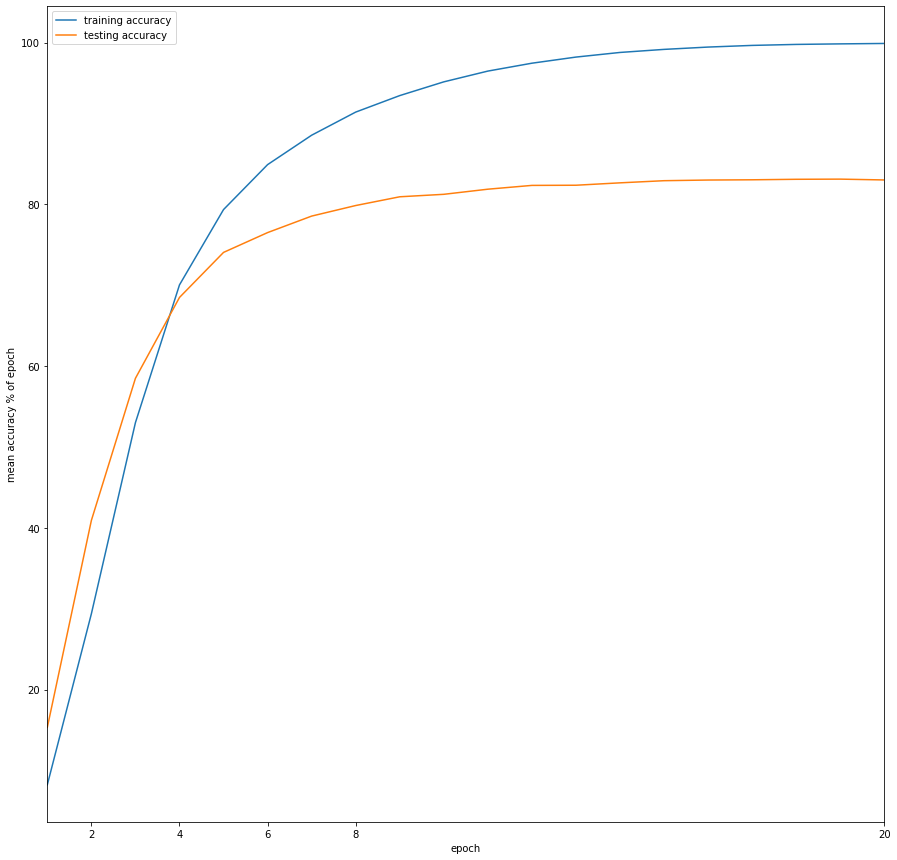

In [33]:
learning_rates

[1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001]

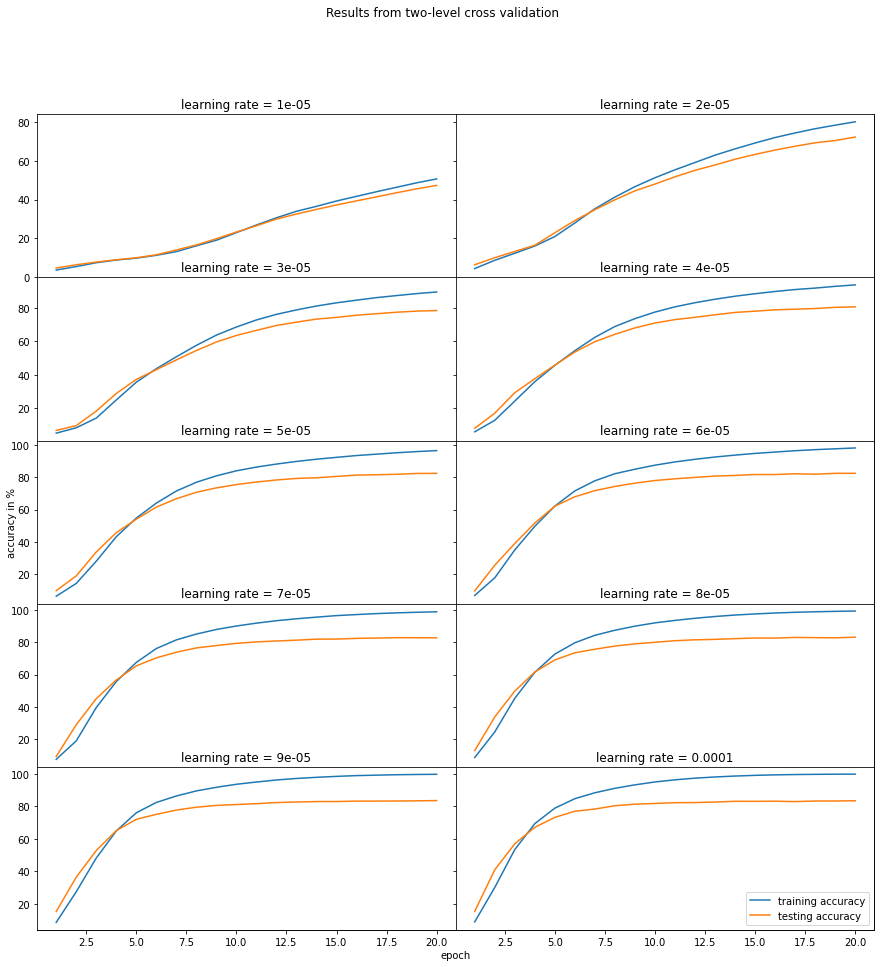

In [61]:
trainacc = [[],[],[],[],[],[],[],[],[],[]]
testacc = [[],[],[],[],[],[],[],[],[],[]]
for j in range(num_epochs):
    for x in range(len(learning_rates)):
        testsums = []
        trainsums = []
        for i in range(1,k+1):
            testsums.append(foldperf['fold'+str(i)]['lr'+str(learning_rates[x])]['test_acc'][j])
            trainsums.append(foldperf['fold'+str(i)]['lr'+str(learning_rates[x])]['train_acc'][j])
        trainacc[x].append(np.mean(trainsums))
        testacc[x].append(np.mean(testsums))

# plt.figure(figsize=(15,15))
# plt.plot(np.arange(1,num_epochs+1), trainacc, label='training accuracy')
# plt.plot(np.arange(1,num_epochs+1), testacc, label='testing accuracy')
# plt.ylabel('mean accuracy % of epoch')
# plt.xlabel('epoch')
# plt.xticks([0,2,4,6,8,num_epochs])
# plt.legend()
# plt.xlim((1,num_epochs))
# plt.show()
x = np.arange(1, num_epochs+1)
fig = plt.figure(figsize=(15,15))
plt.xlabel('epoch', labelpad=20)
plt.ylabel('accuracy in %', labelpad=20)
plt.xticks([])
plt.yticks([])
gs = fig.add_gridspec(5, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Results from two-level cross validation')
ax1.plot(x, trainacc[0], label = 'training accuracy')
ax1.plot(x, testacc[0], label = 'testing accuracy')
ax1.set_title('learning rate = '+str(learning_rates[0]))
ax2.plot(x, trainacc[1], label = 'training accuracy')
ax2.plot(x, testacc[1], label = 'testing accuracy')
ax2.set_title('learning rate = '+str(learning_rates[1]))
ax3.plot(x, trainacc[2], label = 'training accuracy')
ax3.plot(x, testacc[2], label = 'testing accuracy')
ax3.set_title('learning rate = '+str(learning_rates[2]))
ax4.plot(x, trainacc[3], label = 'training accuracy')
ax4.plot(x, testacc[3], label = 'testing accuracy')
ax4.set_title('learning rate = '+str(learning_rates[3]))
ax5.plot(x, trainacc[4], label = 'training accuracy')
ax5.plot(x, testacc[4], label = 'testing accuracy')
ax5.set_title('learning rate = '+ str(learning_rates[4]))
ax6.plot(x, trainacc[5], label = 'training accuracy')
ax6.plot(x, testacc[5], label = 'testing accuracy')
ax6.set_title('learning rate = '+ str(learning_rates[5]))
ax7.plot(x, trainacc[6], label = 'training accuracy')
ax7.plot(x, testacc[6], label = 'testing accuracy')
ax7.set_title('learning rate = '+ str(learning_rates[6]))
ax8.plot(x, trainacc[7], label = 'training accuracy')
ax8.plot(x, testacc[7], label = 'testing accuracy')
ax8.set_title('learning rate = '+ str(learning_rates[7]))
ax9.plot(x, trainacc[8], label = 'training accuracy')
ax9.plot(x, testacc[8], label = 'testing accuracy')
ax9.set_title('learning rate = '+ str(learning_rates[8]))
ax10.plot(x, trainacc[9], label = 'training accuracy')
ax10.plot(x, testacc[9], label = 'testing accuracy')
ax10.set_title('learning rate = '+ str(learning_rates[9]))
plt.legend()

for ax in fig.get_axes():
    ax.label_outer()

In [77]:
H1 = round(math.sqrt(M * 30))
H2 = round(H1/2)
H3 = round(H2/2)
foldperf={}
num_epochs=20
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net(M,H1,H2,H3,30)
    model.to(device)
    learning_rate=0.00009
    #optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,loss_fn,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
    #lrdict['lr{}'.format(learning_rate)] = history
        foldperf['fold{}'.format(fold+1)] = history#['lr{}'.format(learning_rate)] = history

Fold 1
Epoch:1/20 AVG Training Loss:3.349 AVG Test Loss:3.245 AVG Training Acc 9.73 % AVG Test Acc 17.23 %
Epoch:2/20 AVG Training Loss:2.966 AVG Test Loss:2.690 AVG Training Acc 26.49 % AVG Test Acc 37.51 %
Epoch:3/20 AVG Training Loss:2.303 AVG Test Loss:2.067 AVG Training Acc 47.91 % AVG Test Acc 53.41 %
Epoch:4/20 AVG Training Loss:1.720 AVG Test Loss:1.649 AVG Training Acc 66.04 % AVG Test Acc 63.20 %
Epoch:5/20 AVG Training Loss:1.309 AVG Test Loss:1.359 AVG Training Acc 76.79 % AVG Test Acc 70.23 %
Epoch:6/20 AVG Training Loss:1.011 AVG Test Loss:1.160 AVG Training Acc 82.64 % AVG Test Acc 75.54 %
Epoch:7/20 AVG Training Loss:0.784 AVG Test Loss:1.015 AVG Training Acc 87.11 % AVG Test Acc 77.57 %
Epoch:8/20 AVG Training Loss:0.619 AVG Test Loss:0.924 AVG Training Acc 89.81 % AVG Test Acc 78.19 %
Epoch:9/20 AVG Training Loss:0.493 AVG Test Loss:0.861 AVG Training Acc 92.39 % AVG Test Acc 78.49 %
Epoch:10/20 AVG Training Loss:0.401 AVG Test Loss:0.805 AVG Training Acc 94.29 % AVG 

Epoch:2/20 AVG Training Loss:2.949 AVG Test Loss:2.633 AVG Training Acc 25.83 % AVG Test Acc 37.45 %
Epoch:3/20 AVG Training Loss:2.271 AVG Test Loss:2.003 AVG Training Acc 50.28 % AVG Test Acc 57.86 %
Epoch:4/20 AVG Training Loss:1.685 AVG Test Loss:1.585 AVG Training Acc 68.82 % AVG Test Acc 66.73 %
Epoch:5/20 AVG Training Loss:1.272 AVG Test Loss:1.325 AVG Training Acc 77.62 % AVG Test Acc 71.33 %
Epoch:6/20 AVG Training Loss:0.977 AVG Test Loss:1.155 AVG Training Acc 83.89 % AVG Test Acc 75.31 %
Epoch:7/20 AVG Training Loss:0.765 AVG Test Loss:1.019 AVG Training Acc 87.41 % AVG Test Acc 77.04 %
Epoch:8/20 AVG Training Loss:0.608 AVG Test Loss:0.921 AVG Training Acc 90.42 % AVG Test Acc 79.18 %
Epoch:9/20 AVG Training Loss:0.489 AVG Test Loss:0.884 AVG Training Acc 92.51 % AVG Test Acc 79.08 %
Epoch:10/20 AVG Training Loss:0.396 AVG Test Loss:0.827 AVG Training Acc 94.23 % AVG Test Acc 80.10 %
Epoch:11/20 AVG Training Loss:0.322 AVG Test Loss:0.802 AVG Training Acc 95.69 % AVG Test 

Epoch:3/20 AVG Training Loss:2.303 AVG Test Loss:2.111 AVG Training Acc 47.37 % AVG Test Acc 49.90 %
Epoch:4/20 AVG Training Loss:1.737 AVG Test Loss:1.669 AVG Training Acc 64.48 % AVG Test Acc 64.18 %
Epoch:5/20 AVG Training Loss:1.327 AVG Test Loss:1.370 AVG Training Acc 76.65 % AVG Test Acc 72.04 %
Epoch:6/20 AVG Training Loss:1.022 AVG Test Loss:1.145 AVG Training Acc 82.68 % AVG Test Acc 75.82 %
Epoch:7/20 AVG Training Loss:0.796 AVG Test Loss:0.997 AVG Training Acc 86.72 % AVG Test Acc 77.96 %
Epoch:8/20 AVG Training Loss:0.625 AVG Test Loss:0.892 AVG Training Acc 89.65 % AVG Test Acc 78.27 %
Epoch:9/20 AVG Training Loss:0.500 AVG Test Loss:0.816 AVG Training Acc 91.92 % AVG Test Acc 79.90 %
Epoch:10/20 AVG Training Loss:0.401 AVG Test Loss:0.744 AVG Training Acc 93.80 % AVG Test Acc 81.12 %
Epoch:11/20 AVG Training Loss:0.326 AVG Test Loss:0.703 AVG Training Acc 95.24 % AVG Test Acc 81.94 %
Epoch:12/20 AVG Training Loss:0.267 AVG Test Loss:0.684 AVG Training Acc 96.46 % AVG Test

In [108]:
def accuracyEachClass(model,device,dataloader):
    classes = np.arange(0,29)
    classes = list(classes)
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for inputs, labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)
        scores, predictions = torch.max(output.data,1)
        for label, prediction in zip(labels, predictions):
            label = int(label)
            if label == prediction:
                correct_pred[int(classes[label])] += 1
            total_pred[int(classes[label])] += 1
    return correct_pred, total_pred

cor,tot = accuracyEachClass(model,device,test_loader)

# print accuracy for each class
for classname, correct_count in cor.items():
    accuracy = 100 * float(correct_count) / tot[classname]
    print(f'Accuracy for class: {names[classname]:25s} is {accuracy:.1f} %')

Accuracy for class: Pam Key                   is 93.8 %
Accuracy for class: Associated Press          is 54.8 %
Accuracy for class: Charlie Spiering          is 73.0 %
Accuracy for class: Jerome Hudson             is 82.8 %
Accuracy for class: John Hayward              is 73.5 %
Accuracy for class: Daniel Nussbaum           is 89.5 %
Accuracy for class: AWR Hawkins               is 100.0 %
Accuracy for class: Ian Hanchett              is 93.8 %
Accuracy for class: Joel B. Pollak            is 87.2 %
Accuracy for class: Post Editorial Board      is 92.9 %
Accuracy for class: Alex Swoyer               is 84.6 %
Accuracy for class: Camila Domonoske          is 54.3 %
Accuracy for class: Warner Todd Huston        is 92.6 %
Accuracy for class: NPR Staff                 is 94.9 %
Accuracy for class: Jeff Poor                 is 93.1 %
Accuracy for class: Merrit Kennedy            is 62.9 %
Accuracy for class: Trent Baker               is 97.3 %
Accuracy for class: Breitbart London          i

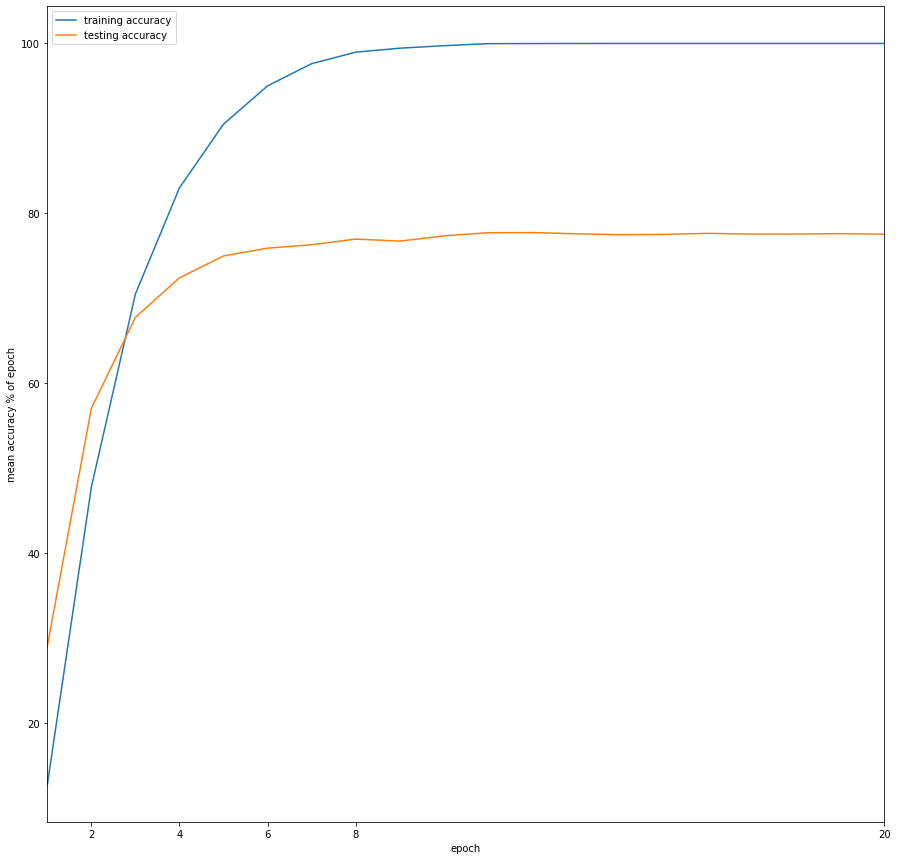

In [67]:
# trainacc = []
# testacc = []
# for j in range(num_epochs):
#     testsums = []
#     trainsums = []
#     for i in range(1,k+1):
#         testsums.append(foldperf['fold'+str(i)]['test_acc'][j])
#         trainsums.append(foldperf['fold'+str(i)]['train_acc'][j])
#     trainacc.append(np.mean(trainsums))
#     testacc.append(np.mean(testsums))
# plt.figure(figsize=(15,15))
# plt.plot(np.arange(1,num_epochs+1), trainacc, label='training accuracy')
# plt.plot(np.arange(1,num_epochs+1), testacc, label='testing accuracy')
# plt.ylabel('mean accuracy % of epoch')
# plt.xlabel('epoch')
# plt.xticks([0,2,4,6,8,num_epochs])
# plt.legend()
# plt.xlim((1,num_epochs))
# plt.show()